In [1]:
import pandas as pd

In [2]:
# Read the CSV file
file_path = 'Data/diabetes_data.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)
df.head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Reviewing Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   70692 non-null  float64
 1   Sex                   70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  GenHlth               70692 non-null  float64
 12  MentHlth              70692 non-null  float64
 13  PhysHlth              70692 non-null  float64
 14  DiffWalk              70692 non-null  float64
 15  Stroke             

In [4]:
import os
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Adjust the file path 
file_path = os.path.join(os.getcwd(), 'Data', 'diabetes_data.csv')  # Assuming the script is in the parent folder of "Data"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset file not found at {file_path}. Ensure the file is in the 'Data' folder.")


In [5]:
# Load the dataset
diabetes_data = pd.read_csv(file_path)

In [6]:
# Rename column to match schema if necessary
if 'HvyAlcoholConsump' in diabetes_data.columns:
    diabetes_data.rename(columns={'HvyAlcoholConsump': 'hvyalcohol'}, inplace=True)

# Create a SQLite database and load the data
db_connection = sqlite3.connect('diabetes_project.db')
cursor = db_connection.cursor()

schema_sql = """
DROP TABLE IF EXISTS diabetes;

CREATE TABLE diabetes (
    age FLOAT,
    sex FLOAT,
    highchol FLOAT,
    cholcheck FLOAT,
    bmi FLOAT,
    smoker FLOAT,
    heartdiseaseorattack FLOAT,
    physactivity FLOAT,
    fruits FLOAT,
    veggies FLOAT,
    hvyalcohol FLOAT,
    genhlth FLOAT,
    menthlth FLOAT,
    physhlth FLOAT,
    diffwalk FLOAT,
    stroke FLOAT,
    highbp FLOAT,
    diabetes FLOAT
);
"""

cursor.executescript(schema_sql)
db_connection.commit()

In [7]:
# Load data into the SQLite database
diabetes_data.to_sql('diabetes', db_connection, if_exists='append', index=False)

70692

In [8]:
# Fetch the data back from SQLite
query = "SELECT * FROM diabetes"
diabetes_df = pd.read_sql_query(query, db_connection)
db_connection.close()

In [9]:
# Separate features (X) and target variable (y)
X = diabetes_df.drop(columns=['diabetes'])
y = diabetes_df['diabetes']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Simplified hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

# Initialize and fit GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=1)

In [12]:
# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Save optimization results to a CSV file
results_df = pd.DataFrame(grid_search.cv_results_)
results_path = 'model_optimization_results.csv'
results_df.to_csv(results_path, index=False)

In [13]:
# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

In [14]:
# Print final results
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Final Test Set Accuracy:", final_accuracy)
print("\nClassification Report:\n", classification_report_output)
print("\nResults saved to:", results_path)

Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Score: 0.7472718289028135
Final Test Set Accuracy: 0.7522161448509996

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.71      0.74     10601
         1.0       0.73      0.79      0.76     10607

    accuracy                           0.75     21208
   macro avg       0.75      0.75      0.75     21208
weighted avg       0.75      0.75      0.75     21208


Results saved to: model_optimization_results.csv


In [16]:
# Random Forests in sklearn will automatically calculate feature importance
importances = best_model.feature_importances_
# We can sort the features by their importance
sorted(zip(best_model.feature_importances_, X.columns), reverse=True)

[(0.2539967850177678, 'highbp'),
 (0.23951845845311748, 'genhlth'),
 (0.1344431531211503, 'bmi'),
 (0.09708067396989616, 'age'),
 (0.09448256529112141, 'highchol'),
 (0.04754218297481927, 'diffwalk'),
 (0.02770426925790021, 'physhlth'),
 (0.02605024623796218, 'heartdiseaseorattack'),
 (0.016350904482198034, 'menthlth'),
 (0.01192807037899404, 'hvyalcohol'),
 (0.009212593288921305, 'sex'),
 (0.008483756970324392, 'cholcheck'),
 (0.00837069608142925, 'physactivity'),
 (0.007996566963131497, 'stroke'),
 (0.0058377803128300656, 'smoker'),
 (0.005712850701953117, 'veggies'),
 (0.00528844649648349, 'fruits')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

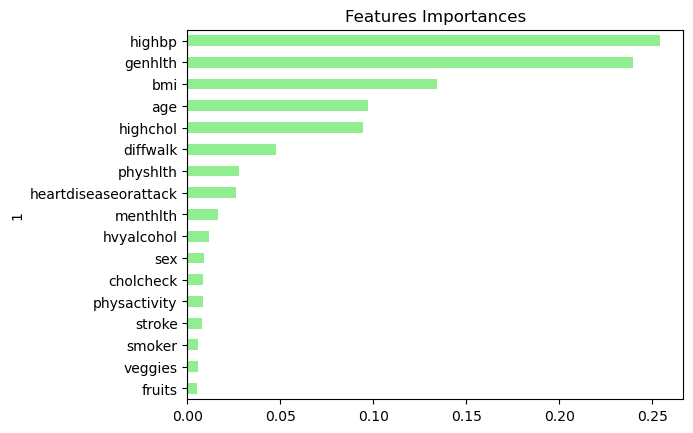

In [17]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)